# Convert of TensorFlow Hub models to OpenVINO Intermediate Representation (IR)
This tutorial demonstrates step-by-step instructions on how to convert models loaded from TensorFlow Hub using OpenVINO Runtime.

You have the flexibility to run this tutorial notebook in its entirety or selectively execute specific sections, as each section operates independently.

## Image classification

We will use the [MobileNet_v2](https://arxiv.org/abs/1704.04861) image classification model from [TensorFlow Hub](https://tfhub.dev/).

MobileNetV2 is a compact and efficient deep learning architecture designed for mobile and embedded devices, developed by Google researchers. It builds on the success of the original MobileNet by introducing improvements in both speed and accuracy. MobileNetV2 employs a streamlined architecture with inverted residual blocks, making it highly efficient for real-time applications while minimizing computational resources. This network excels in tasks like image classification, object detection, and image segmentation, offering a balance between model size and performance. MobileNetV2 has become a popular choice for on-device AI applications, enabling faster and more efficient deep learning inference on smartphones and edge devices.

- [Model page](https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/classification/5) on TensorFlow Hub

### Install required packages

In [1]:
%pip install -q tensorflow_hub tensorflow pillow numpy matplotlib
#  TODO: install OpenVINO where https://github.com/openvinotoolkit/openvino/pull/19892 is included

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


### Import libraries

In [2]:
from pathlib import Path
import os
from urllib.request import urlretrieve
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import tensorflow_hub as hub
import tensorflow as tf
import PIL
import numpy as np
import matplotlib.pyplot as plt

import openvino as ov

tf.get_logger().setLevel("ERROR")

In [3]:
IMAGE_SHAPE = (224, 224)
IMAGE_URL, IMAGE_PATH = "https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg", "data/grace_hopper.jpg"
MODEL_URL, MODEL_PATH = "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/classification/5", "models/mobilenet_v2_100_224.xml"

### Download the classifier
Select a MobileNetV2 pre-trained model [from TensorFlow Hub](https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/classification/5) and wrap it as a Keras layer with `hub.KerasLayer`.

In [4]:
model = hub.KerasLayer(MODEL_URL, input_shape=IMAGE_SHAPE+(3,))

### Download a single image to try the model on

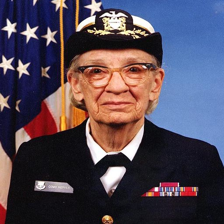

In [5]:
Path(IMAGE_PATH).parent.mkdir(parents=True, exist_ok=True)
grace_hopper, _ = urlretrieve(IMAGE_URL, IMAGE_PATH)
grace_hopper = PIL.Image.open(grace_hopper).resize(IMAGE_SHAPE)
grace_hopper

In [6]:
grace_hopper = np.array(grace_hopper)/255.0
grace_hopper.shape

(224, 224, 3)

### Convert model to OpenVINO IR

We will convert the loaded model to OpenVINO IR using `ov.convert_model` function. We pass the model object to it, no additional arguments required. Then, we save the model to disk using `ov.save_model` function.

In [7]:
if not Path(MODEL_PATH).exists():
    Path(MODEL_PATH).parent.mkdir(parents=True, exist_ok=True)
    converted_model = ov.convert_model(model)
    ov.save_model(converted_model, MODEL_PATH)

### Select inference device

select device from dropdown list for running inference using OpenVINO

In [8]:
import ipywidgets as widgets

core = ov.Core()

device = widgets.Dropdown(
    options=core.available_devices + ["AUTO"],
    value='AUTO',
    description='Device:',
    disabled=False,
)

device

Dropdown(description='Device:', index=4, options=('CPU', 'GPU.0', 'GPU.1', 'GPU.2', 'AUTO'), value='AUTO')

In [9]:
compiled_model = core.compile_model(MODEL_PATH, device_name=device.value)

In [10]:
compiled_model = ov.compile_model(MODEL_PATH)

### Inference

Add a batch dimension (with `np.newaxis`) and pass the image to the model:

In [11]:
output = compiled_model(grace_hopper[np.newaxis, ...])[0]
output.shape

(1, 1001)

The result is a 1001-element vector of logits, rating the probability of each class for the image.

The top class ID can be found with `np.argmax`:

In [12]:
predicted_class = np.argmax(output[0], axis=-1)
predicted_class

653

Take the `predicted_class` ID (such as `653`) and fetch the ImageNet dataset labels to decode the predictions:

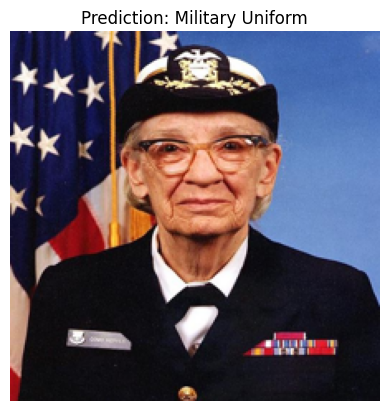

In [13]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())
plt.imshow(grace_hopper)
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class]
_ = plt.title("Prediction: " + predicted_class_name.title())

## Image style transfer

We will use [arbitrary image stylization model](https://arxiv.org/abs/1705.06830) from [TensorFlow Hub](https://tfhub.dev).

The model contains conditional instance normalization (CIN) layers 

The CIN network consists of two main components: a feature extractor and a stylization module. The feature extractor extracts a set of features from the content image. The stylization module then uses these features to generate a stylized image.

The stylization module is a stack of convolutional layers. Each convolutional layer is followed by a CIN layer. The CIN layer takes the features from the previous layer and the CIN parameters from the style image as input and produces a new set of features as output.

The output of the stylization module is a stylized image. The stylized image has the same content as the original content image, but the style has been transferred from the style image.

The CIN network is able to stylize images in real time because it is very efficient. 



- [Model page on TensorFlow Hub](https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2).

### Install required packages

In [1]:
#  TODO: install OpenVINO where https://github.com/openvinotoolkit/openvino/pull/19892 is included
%pip install -q tensorflow tensorflow_hub "opencv-python" numpy matplotlib

  ERROR: HTTP error 404 while getting http://10.211.120.125/openvino_ci/private_builds/dldt/master/commit/0675d9fd8b9c7e7eca198578c42fac08728759ac/private_linux_ubuntu_22_04_release/wheels/openvino-2023.2.0.dev20230912-12388-cp310-cp310-manylinux_2_35_x86_64.whl
ERROR: Could not install requirement openvino==2023.2.0.dev20230912 from http://10.211.120.125/openvino_ci/private_builds/dldt/master/commit/0675d9fd8b9c7e7eca198578c42fac08728759ac/private_linux_ubuntu_22_04_release/wheels/openvino-2023.2.0.dev20230912-12388-cp310-cp310-manylinux_2_35_x86_64.whl because of HTTP error 404 Client Error: Not Found for url: http://10.211.120.125/openvino_ci/private_builds/dldt/master/commit/0675d9fd8b9c7e7eca198578c42fac08728759ac/private_linux_ubuntu_22_04_release/wheels/openvino-2023.2.0.dev20230912-12388-cp310-cp310-manylinux_2_35_x86_64.whl for URL http://10.211.120.125/openvino_ci/private_builds/dldt/master/commit/0675d9fd8b9c7e7eca198578c42fac08728759ac/private_linux_ubuntu_22_04_release/whe

In [2]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
from urllib.request import urlretrieve
from pathlib import Path

import openvino as ov

import tensorflow_hub as hub
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [3]:
CONTENT_IMAGE_URL = "https://upload.wikimedia.org/wikipedia/commons/2/26/YellowLabradorLooking_new.jpg"
CONTENT_IMAGE_PATH = "./data/YellowLabradorLooking_new.jpg"

STYLE_IMAGE_URL = "https://upload.wikimedia.org/wikipedia/commons/b/b4/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg"
STYLE_IMAGE_PATH = "./data/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg"

MODEL_URL = "https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2"
MODEL_PATH = "./models/arbitrary-image-stylization-v1-256.xml"

### Load the model

We load the model from TensorFlow Hub using `hub.KerasLayer`. Since the model has multiple inputs (content image and style image), we need to build it by calling with placeholders and wrap in `tf.keras.Model` function.

In [4]:
inputs = {
    "placeholder": tf.keras.layers.Input(shape=(None, None, 3)),
    "placeholder_1": tf.keras.layers.Input(shape=(None, None, 3)),
}
model = hub.KerasLayer(MODEL_URL, signature="serving_default", signature_outputs_as_dict=True) # define the signature to allow passing inputs as a dictionary
outputs = model(inputs)
model = tf.keras.Model(inputs=inputs, outputs=outputs)

### Convert the model to OpenVINO IR

We convert the loaded model to OpenVINO IR using `ov.convert_model` function. We pass our model to the function, no additional arguments needed. After converting, we save the model to disk using `ov.save_model` function. 

In [5]:
if not Path(MODEL_PATH).exists():
    Path(MODEL_PATH).parent.mkdir(parents=True, exist_ok=True)
    converted_model = ov.convert_model(model)
    ov.save_model(converted_model, MODEL_PATH)

### Select inference device

select device from dropdown list for running inference using OpenVINO

In [6]:
import ipywidgets as widgets

core = ov.Core()

device = widgets.Dropdown(
    options=core.available_devices + ["AUTO"],
    value='AUTO',
    description='Device:',
    disabled=False,
)

device

Dropdown(description='Device:', index=4, options=('CPU', 'GPU.0', 'GPU.1', 'GPU.2', 'AUTO'), value='AUTO')

In [7]:
compiled_model = core.compile_model(MODEL_PATH, device_name=device.value)

### Inference

In [8]:
def download_image(src, dst):
    if not Path(dst).exists():
        Path(dst).parent.mkdir(parents=True, exist_ok=True)
        urlretrieve(src, dst)
    image = cv2.imread(dst)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert image color to RGB space
    image = image / 255  # Normalize to [0, 1] interval
    image = image.astype(np.float32)
    return image

In [9]:
content_image = download_image(CONTENT_IMAGE_URL, CONTENT_IMAGE_PATH)
style_image = download_image(STYLE_IMAGE_URL, STYLE_IMAGE_PATH)
style_image = cv2.resize(style_image, (256,256)) # model was trained on 256x256 images

In [10]:
result = compiled_model([content_image[np.newaxis, ...], style_image[np.newaxis, ...]])[0]

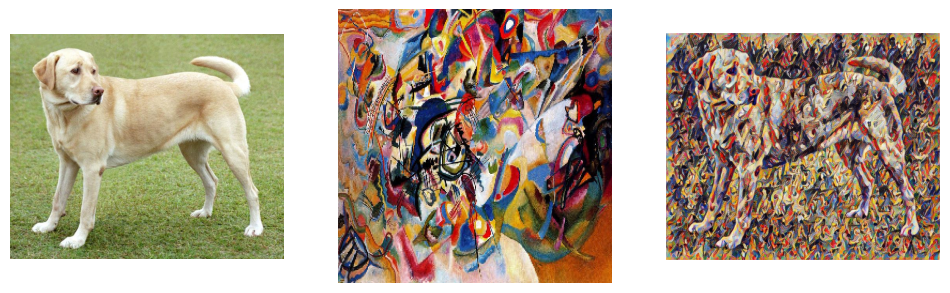

In [11]:
plt.figure(figsize=(12,12))
for i, k in enumerate([content_image, style_image, result[0]]):
    ax = plt.subplot(1, 3, i+1)
    plt.imshow(k)
    plt.axis("off")